##### This is an initial simple toy example for MDNs borrowed from:
http://blog.otoro.net/2015/11/24/mixture-density-networks-with-tensorflow/

The first part of this notebook demonstrates that inverse models are in general harder to learn than forward models. It can actually be shown that by minimising a quadratic loss an underlying parametrised model for regression is actually attempting to fit a uni-modal distribution (i.e. a Gaussian) to the sample data used for training, even the the sampled data is actually coming from a multi-modal probability distribution (http://eprints.aston.ac.uk/373/1/NCRG_94_004.pdf). In the case of inverse functions/models, the multi-modality nature of the source distribution from which samples are collected causes models that are trained with quadratic loss to have poor performance. To overcome this problem, Bishop proposed Mixture Density Networks, a kind of network that outputs the parameters of a mixture, and therefore is able to model arbitrary multi-modal probability distributions.

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import os, sys

In [4]:
path = os.path.abspath(os.path.join(os.getcwd(), '..', ''))
print path

/Users/ermanoarruda/Projects/ros_ws/aml/aml_robot/src/aml_dl/mdn


In [5]:
sys.path.append(path)

In [ ]:
import tensorflow as tf
from model import simple_mdn_model, get_loss, KMIX

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import math

In [ ]:
NSAMPLE = 1000
x_data = np.float32(np.random.uniform(-10.5, 10.5, (1, NSAMPLE))).T
r_data = np.float32(np.random.normal(size=(NSAMPLE,1)))
y_data = np.float32(np.sin(0.75*x_data)*7.0+x_data*0.5+r_data*1.0)

plt.figure(figsize=(8, 8))
plot_out = plt.plot(x_data,y_data,'ro',alpha=0.3)
plt.show()

In [ ]:
x = tf.placeholder(dtype=tf.float32, shape=[None,1])
y = tf.placeholder(dtype=tf.float32, shape=[None,1])

In [ ]:
NHIDDEN = 20
W = tf.Variable(tf.random_normal([1,NHIDDEN], stddev=1.0, dtype=tf.float32))
b = tf.Variable(tf.random_normal([1,NHIDDEN], stddev=1.0, dtype=tf.float32))

W_out = tf.Variable(tf.random_normal([NHIDDEN,1], stddev=1.0, dtype=tf.float32))
b_out = tf.Variable(tf.random_normal([1,1], stddev=1.0, dtype=tf.float32))

hidden_layer = tf.nn.tanh(tf.matmul(x, W) + b)
y_out = tf.matmul(hidden_layer,W_out) + b_out

In [30]:
lossfunc = tf.nn.l2_loss(y_out-y);

In [31]:
train_op = tf.train.RMSPropOptimizer(learning_rate=0.1, decay=0.8).minimize(lossfunc)

In [32]:
sess = tf.InteractiveSession()
sess.run(tf.initialize_all_variables())


In [33]:
NEPOCH = 1000
for i in range(NEPOCH):
  sess.run(train_op,feed_dict={x: x_data, y: y_data})

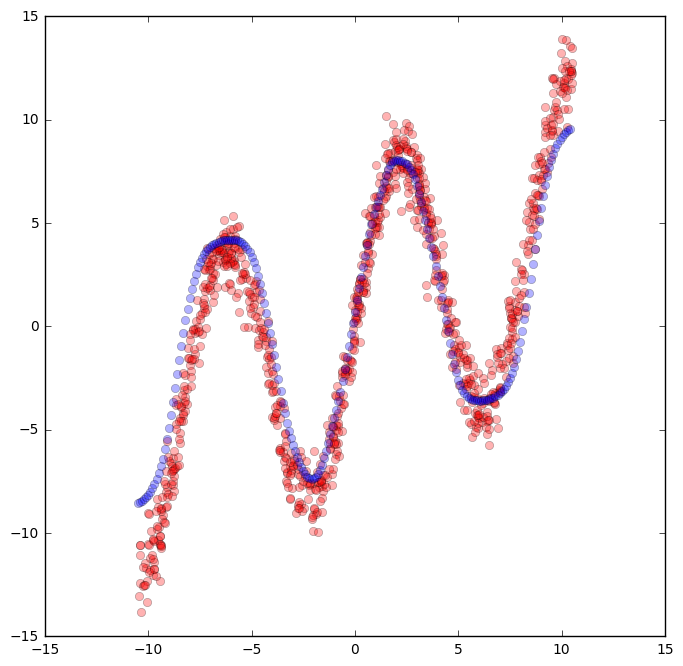

In [34]:
x_test = np.float32(np.arange(-10.5,10.5,0.1))
x_test = x_test.reshape(x_test.size,1)
y_test = sess.run(y_out,feed_dict={x: x_test})

plt.figure(figsize=(8, 8))
plt.plot(x_data,y_data,'ro', x_test,y_test,'bo',alpha=0.3)
plt.show()

sess.close()

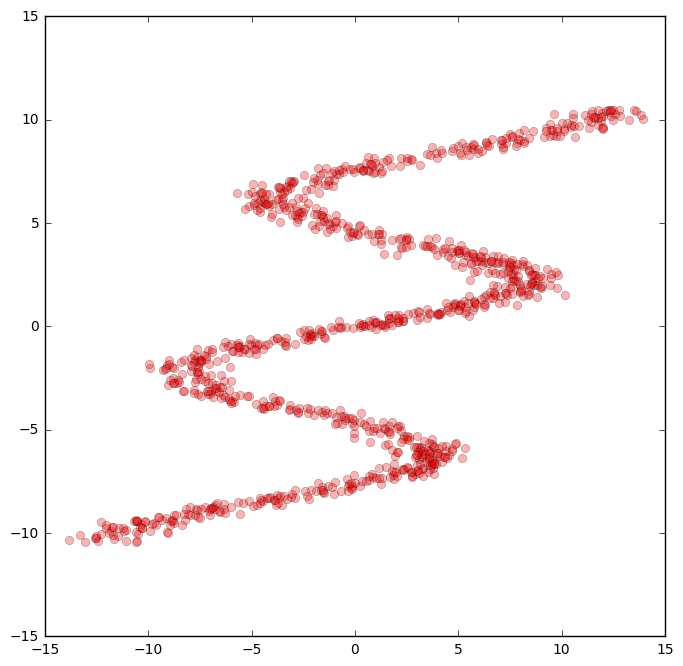

In [35]:
temp_data = x_data
x_data = y_data
y_data = temp_data

plt.figure(figsize=(8, 8))
plot_out = plt.plot(x_data,y_data,'ro',alpha=0.3)
plt.show()

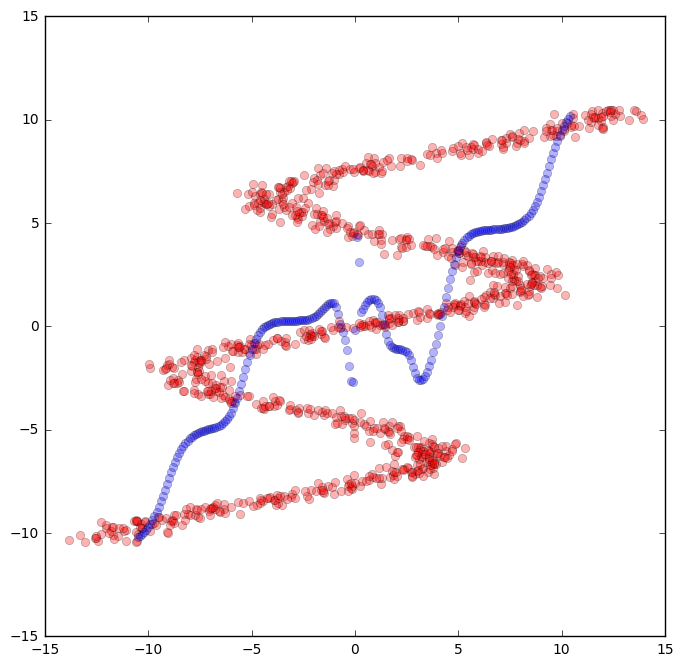

In [36]:
sess = tf.InteractiveSession()
sess.run(tf.initialize_all_variables())

for i in range(NEPOCH):
  sess.run(train_op,feed_dict={x: x_data, y: y_data})

x_test = np.float32(np.arange(-10.5,10.5,0.1))
x_test = x_test.reshape(x_test.size,1)
y_test = sess.run(y_out,feed_dict={x: x_test})

plt.figure(figsize=(8, 8))
plt.plot(x_data,y_data,'ro', x_test,y_test,'bo',alpha=0.3)
plt.show()

sess.close()

# MDN

In [37]:
out_pi, out_sigma, out_mu, lossfunc, x, y = simple_mdn_model()
train_op = tf.train.AdamOptimizer().minimize(lossfunc)

RuntimeError: maximum recursion depth exceeded

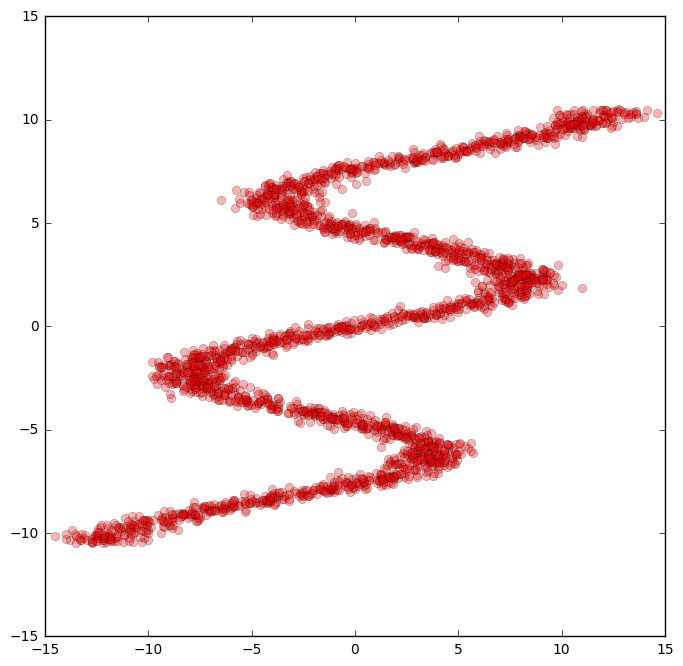

In [38]:
NSAMPLE = 2500

y_data = np.float32(np.random.uniform(-10.5, 10.5, (1, NSAMPLE))).T
r_data = np.float32(np.random.normal(size=(NSAMPLE,1))) # random noise
x_data = np.float32(np.sin(0.75*y_data)*7.0+y_data*0.5+r_data*1.0)

plt.figure(figsize=(8, 8))
plt.plot(x_data,y_data,'ro', alpha=0.3)
plt.show()

In [20]:
sess = tf.InteractiveSession()
sess.run(tf.initialize_all_variables())

NEPOCH = 10000
loss = np.zeros(NEPOCH) # store the training progress here.
for i in range(NEPOCH):
  sess.run(train_op,feed_dict={x: x_data, y: y_data})
  loss[i] = sess.run(lossfunc, feed_dict={x: x_data, y: y_data})

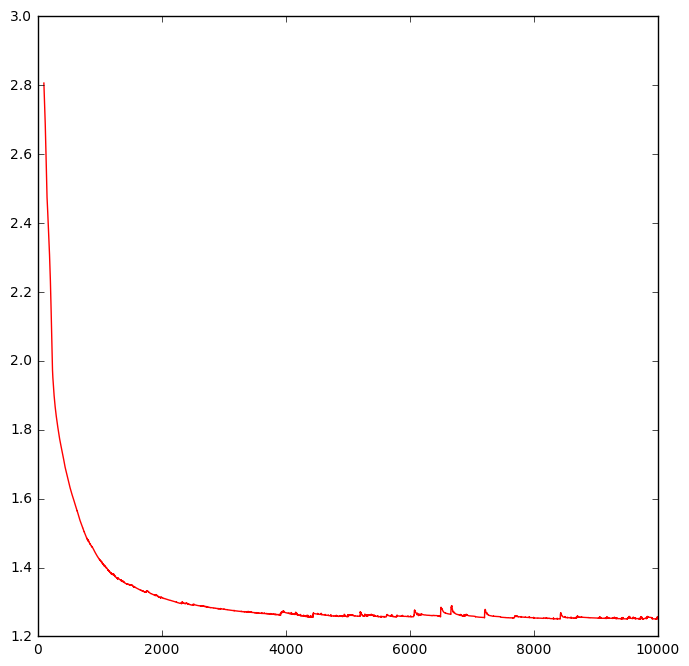

In [21]:
plt.figure(figsize=(8, 8))
plt.plot(np.arange(100, NEPOCH,1), loss[100:], 'r-')
plt.show()

In [22]:
x_test = np.float32(np.arange(-15,15,0.1))
NTEST = x_test.size
x_test = x_test.reshape(NTEST,1) # needs to be a matrix, not a vector

def get_pi_idx(x, pdf):
  N = pdf.size
  accumulate = 0
  for i in range(0, N):
    accumulate += pdf[i]
    if (accumulate >= x):
      return i
  print 'error with sampling ensemble'
  return -1

def generate_ensemble(out_pi, out_mu, out_sigma, M = 10):
  NTEST = x_test.size
  result = np.random.rand(NTEST, M) # initially random [0, 1]
  rn = np.random.randn(NTEST, M) # normal random matrix (0.0, 1.0)
  mu = 0
  std = 0
  idx = 0

  # transforms result into random ensembles
  for j in range(0, M):
    for i in range(0, NTEST):
      idx = get_pi_idx(result[i, j], out_pi[i])
      mu = out_mu[i, idx]
      std = out_sigma[i, idx]
      result[i, j] = mu + rn[i, j]*std
  return result

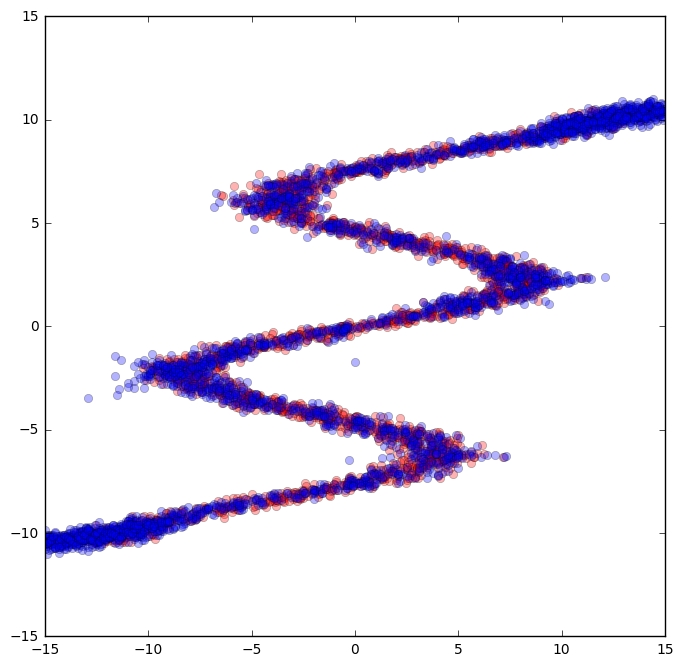

In [23]:
out_pi_test, out_sigma_test, out_mu_test = sess.run([out_pi, out_sigma, out_mu], feed_dict={x: x_test})

y_test = generate_ensemble(out_pi_test, out_mu_test, out_sigma_test)

plt.figure(figsize=(8, 8))
plt.plot(x_data,y_data,'ro', x_test,y_test,'bo',alpha=0.3)
plt.show()

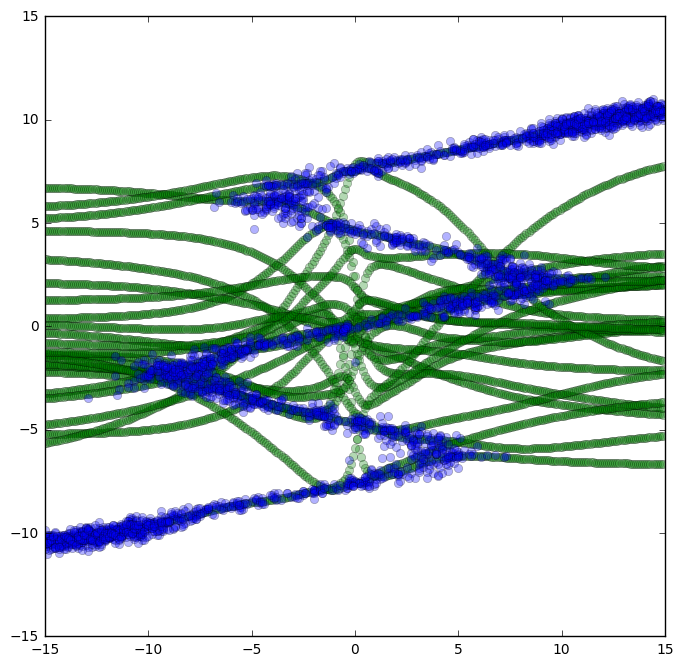

In [24]:
plt.figure(figsize=(8, 8))
plt.plot(x_test,out_mu_test,'go', x_test,y_test,'bo',alpha=0.3)
plt.show()

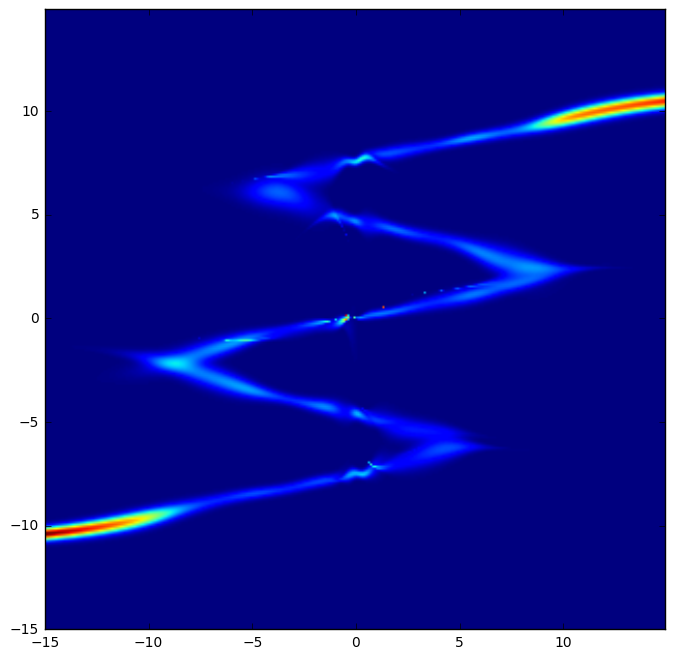

In [25]:
x_heatmap_label = np.float32(np.arange(-15,15,0.1))
y_heatmap_label = np.float32(np.arange(-15,15,0.1))

def custom_gaussian(x, mu, std):
  oneDivSqrtTwoPI = 1 / math.sqrt(2*math.pi)
  x_norm = (x-mu)/std
  result = oneDivSqrtTwoPI*math.exp(-x_norm*x_norm/2)/std
  return result

def generate_heatmap(out_pi, out_mu, out_sigma, x_heatmap_label, y_heatmap_label):
  N = x_heatmap_label.size
  M = y_heatmap_label.size
  K = KMIX

  z = np.zeros((N, M)) # initially random [0, 1]

  mu = 0
  std = 0
  pi = 0

  # transforms result into random ensembles
  for k in range(0, K):
    for i in range(0, M):
      pi = out_pi[i, k]
      mu = out_mu[i, k]
      std = out_sigma[i, k]
      for j in range(0, N):
        z[N-j-1, i] += pi * custom_gaussian(y_heatmap_label[j], mu, std)

  return z

def draw_heatmap(xedges, yedges, heatmap):
  extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
  plt.figure(figsize=(8, 8))
  plt.imshow(heatmap, extent=extent)
  plt.show()

z = generate_heatmap(out_pi_test, out_mu_test, out_sigma_test, x_heatmap_label, y_heatmap_label)
draw_heatmap(x_heatmap_label, y_heatmap_label, z)